### Anomaly Detection

In this project we implement an anomaly detection algorithm to detect anomalous behavior in server computers.

The dataset contains two features -

- throughput (mb/s) and
- latency (ms) of response
  of each server.

While servers were operating, collected 𝑚=307 examples of how they were behaving, and thus have an unlabeled dataset  {𝑥(1),…,𝑥(𝑚)} .

Assume that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.
We use a Gaussian model to detect anomalous examples in your dataset.

We will first start on a 2D dataset that will allow us to visualize what the algorithm is doing.
On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('X_train.csv')
X_train = X_train[['X1', 'X2']].apply(pd.to_numeric).values

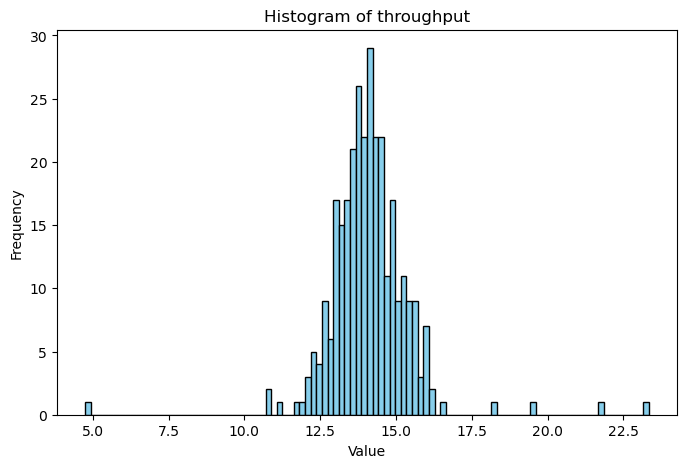

In [3]:
plt.figure(figsize=(8, 5))
plt.hist(X_train[:,0], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of throughput')
plt.show()

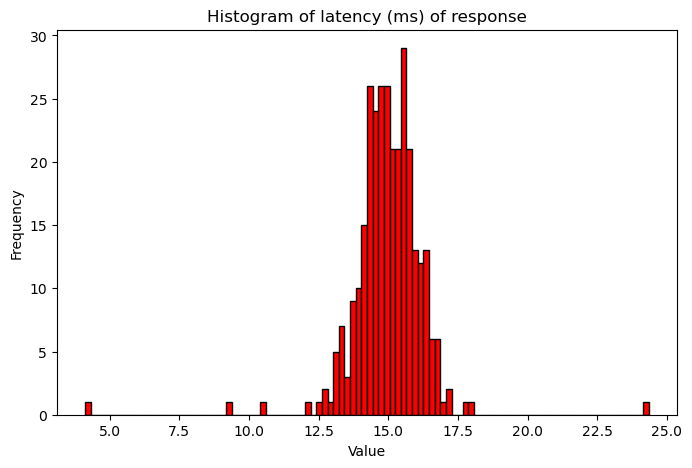

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(X_train[:,1], bins=100, color=['red'], edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of latency (ms) of response')
plt.show()

In [5]:
y_value = pd.read_csv('y_val.csv')

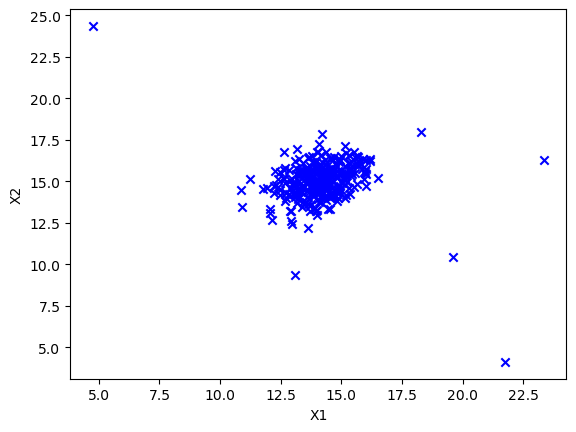

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [7]:
def mu_sigma2_calculation(x):
    m=len(x)
    mean = np.sum(x,axis=0)/m
    variance = np.sum((x-mean)**2,axis=0)/m
    return mean,variance

## Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each
of the features $x_i$. 

* Recall that the Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.


$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)
}$$

$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$
  
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

In [8]:
def gaussian(X, mu, sigma2):
    p =  (1 / ( np.sqrt(2 * np.pi*sigma2))) * np.exp(-0.5 * ((X - mu)**2 / sigma2))
    p = np.prod(p, axis=1) 
    return p

### Selecting the threshold

 $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ where
    * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 


In [9]:
def select_threshold(y_val, p_val): 
    
    y_val = np.array(y_val).flatten()
    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions = p_val < epsilon

        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0

        F1 = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0        
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [10]:
mu, var = mu_sigma2_calculation(X_train)
p_val = gaussian(X_train, mu, var)
epsilon, F1 = select_threshold(y_value, p_val)


In [11]:
epsilon

8.986095082762617e-05

In [12]:
F1

0.7499999999999999

In [13]:
anomalies = np.where(p_val < epsilon)
anom_points = X_train[anomalies]
anom_points.shape

(6, 2)

In [14]:
print("Mean (μ):", mu)
print("Variance (σ²):", var)
print("\nAnomalies detected at indices:", anomalies[0])
print("Anomalous points:\n", X_train[anomalies])

Mean (μ): [14.11222578 14.99771051]
Variance (σ²): [1.83263141 1.70974533]

Anomalies detected at indices: [300 301 303 304 305 306]
Anomalous points:
 [[13.07931049  9.34787812]
 [21.72713402  4.12623222]
 [19.58257277 10.411619  ]
 [23.33986753 16.29887355]
 [18.26118844 17.978309  ]
 [ 4.75261282 24.35040725]]


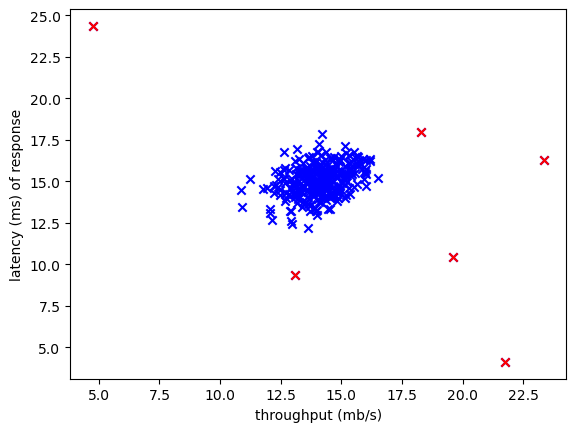

In [16]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b')
plt.scatter(anom_points[:,0], anom_points[:,1], marker='x', c='r')
plt.xlabel('throughput (mb/s)')
plt.ylabel('latency (ms) of response')
plt.show()